#### Boiler Plate

In [1]:
import random
import cv2 as cv
import networkx as nx
import numpy as np
import timeit
import datetime

from noise import pnoise2, snoise2
from matplotlib import pyplot as plt
from scipy.spatial import cKDTree
from scipy import interpolate

from PIL import Image

startTime = datetime.datetime.now()

### Global Parameters Of The Process

In [2]:
# Global Variables
Ps = 0.3 #0.05 ## probability of symetric branch
Pa = 0 #0.3 ## probability of asymetric branch
Pc = 1-(Ps+Pa) ## probability of continium (growth)
inputDomain='taiwan-outline-bigger.png'
inputTerrain='taiwan-terrain-bigger.png'
inputRiverSlope='taiwan-riverslope-bigger.png'
globalseed=4314
N_majorRivers=10
zeta = 10 # elevation range to include in candidate node selection
slopeRate = 30 # Maximum rate at which rivers climb
edgeLength = 20
eta = .75   #   eta * edgeLength is the minimum distance from a node to the coast
sigma = .75 # sigma * edgeLength is the minimum distance between two nodes
rwidth=6 # 
riverAngleDev = 1.7 # Used in picknewnodepos(). Standard Deviation of angle for new node. Increase for less straight rivers
maxTries = 15
outputResolution = 500

# Initializations of nonparameter global variables
nodecounter = 0;
nodes=[]
candidates=[]
G = nx.DiGraph() # a bidirectional graph, represents the hydrological system?
mouthnodes=[]    # the nodes of the major river mouths
Gkd=None         # a ckDTree. represents nodes' positions? implements the paper's terrain model?

#### Load Base Image 

Terrain Outline


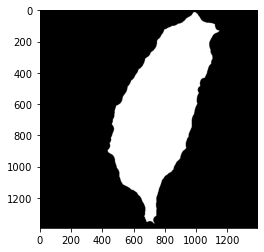

Terrain Slope Input


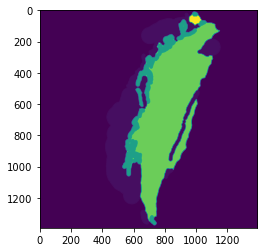

River Slope Input


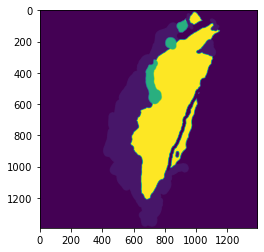

In [3]:
imgorg=cv.imread(inputDomain)
img  = imgorg.copy()
print('Terrain Outline')
plt.imshow(img)
random.seed(globalseed)

terrainSlope = Image.open(inputTerrain)
terrainSlope = terrainSlope.convert('L')
plt.show()
print('Terrain Slope Input')
plt.imshow(terrainSlope)
terrainSlope = terrainSlope.load()

riverSlope = Image.open(inputRiverSlope)
riverSlope = riverSlope.convert('L')
plt.show()
print('River Slope Input')
plt.imshow(riverSlope)
riverSlope = riverSlope.load()

#### Find contour of the ROI, This will be Gamma

In [4]:
imgray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # a black-and-white version of the input image
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
cv.drawContours(img, contours, -1, (0,255,0), 2)
test = cv.cvtColor(thresh, cv.COLOR_GRAY2BGR)

In [5]:
if len(contours) > 1:
    print('WARNING: Multiple contours identified. The program may not have correctly')
    print('identified the land.')

contour = contours[0]
contour=contour.reshape(-1,2)
contour=np.flip(contour,1)

#### Select first point at a ranndom offset, try to select the following points such as that the highest probability ( on a nomal distribution) is that they are furthest away from each other 


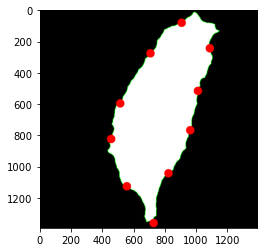

In [6]:
points = []                            # the array of all the river start points
idxes = []                             # parallel with points. This is the index on the contour of each point
random.seed(globalseed)
idx = random.randint(0,len(contour)-1) # the first river
points.append(contour[idx])
idxes.append(idx)
img2 = img.copy()
N=N_majorRivers
dist = len(contours[0])/N
for i in range(1,N):
    newIdx = int((idx+i*dist+random.gauss(0, dist/6))%len(contours[0]))
    idxes.append(newIdx)
    points.append(contour[newIdx])
    img2 = img.copy()
for i in range(len(points)):           # draw circles on the river mouths?
    cv.circle(img2,tuple(np.flip(points[i])), int((img.shape[0] / 512) * 10), (255,0,0),-1)
plt.imshow(img2)

# Network Generation

In [7]:

# Borrowed , all of it
def segments_distance(a,b,c,d):
  """ distance between two segments in the plane:
      one segment is a to b
      the other is   c to d
  """
  #print(a[0],a[1],b[0],b[1],c[0],c[1],d[1],d[0])
  #print(segments_distance_internal(a[0],a[1],b[0],b[1],c[0],c[1],d[1],d[0]))
  return segments_distance_internal(a[0],a[1],b[0],b[1],c[0],c[1],d[0],d[1])

def segments_distance_internal(x11, y11, x12, y12, x21, y21, x22, y22):
  """ distance between two segments in the plane:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
  """
  if segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22): return 0
  # try each of the 4 vertices w/the other segment
  distances = []
  distances.append(point_segment_distance(x11, y11, x21, y21, x22, y22))
  distances.append(point_segment_distance(x12, y12, x21, y21, x22, y22))
  distances.append(point_segment_distance(x21, y21, x11, y11, x12, y12))
  distances.append(point_segment_distance(x22, y22, x11, y11, x12, y12))
  return min(distances)

def segments_intersect(x11, y11, x12, y12, x21, y21, x22, y22):
  """ whether two segments in the plane intersect:
      one segment is (x11, y11) to (x12, y12)
      the other is   (x21, y21) to (x22, y22)
  """
  dx1 = x12 - x11
  dy1 = y12 - y11
  dx2 = x22 - x21
  dy2 = y22 - y21
  delta = dx2 * dy1 - dy2 * dx1
  if delta == 0: return False  # parallel segments
  s = (dx1 * (y21 - y11) + dy1 * (x11 - x21)) / delta
  t = (dx2 * (y11 - y21) + dy2 * (x21 - x11)) / (-delta)
  return (0 <= s <= 1) and (0 <= t <= 1)

import math
# I think this finds the distance between a point and a line segment
def point_segment_distance(px, py, x1, y1, x2, y2):
  dx = x2 - x1
  dy = y2 - y1
  if dx == dy == 0:  # the segment's just a point
    return math.hypot(px - x1, py - y1)

  # Calculate the t that minimizes the distance.
  t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

  # See if this represents one of the segment's
  # end points or a point in the middle.
  if t < 0:
    dx = px - x1
    dy = py - y1
  elif t > 1:
    dx = px - x2
    dy = py - y2
  else:
    near_x = x1 + t * dx
    near_y = y1 + t * dy
    dx = px - near_x
    dy = py - near_y

  return math.hypot(dx, dy)

def point_segment_distance_is_endpoint(px, py, x1, y1, x2, y2):
  dx = x2 - x1
  dy = y2 - y1
  if dx == dy == 0:  # the segment's just a point
    return (math.hypot(px - x1, py - y1), True)

  # Calculate the t that minimizes the distance.
  t = ((px - x1) * dx + (py - y1) * dy) / (dx * dx + dy * dy)

  isEndpoint = True

  # See if this represents one of the segment's
  # end points or a point in the middle.
  if t < 0:
    dx = px - x1
    dy = py - y1
  elif t > 1:
    dx = px - x2
    dy = py - y2
  else:
    near_x = x1 + t * dx
    near_y = y1 + t * dy
    dx = px - near_x
    dy = py - near_y
    isEndpoint = False

  return (math.hypot(dx, dy), isEndpoint)

def point_segment_distance_tuple(p,a,b):
    return point_segment_distance(p[0],p[1],a[0],a[1],b[0],b[1])
    
def segments_intersect_tuple(a1,a2,b1,b2):
    return segments_intersect(a1[0],a1[1],a2[0],a2[1],b1[0],b1[1],b2[0],b2[1])

    

In [8]:
def addNode(pointInspace,Priority):
    global nodecounter
    global nodes
    global candidates
    global G
    global Gkd
    nodes.append(nodecounter)
    candidates.append(nodecounter)
    G.add_node(
        nodecounter,
        pos=(pointInspace[0],pointInspace[1]),
        elevation=pointInspace[2],
        priority=Priority,
        rosgen='',
        flow=0
    ) ## XYZ of initial node, on the border, should be at some threshold above sea level
    nodecounter+=1
    allpoints_list = [[G.nodes[x]['pos'][0],G.nodes[x]['pos'][1]] for x in nodes]
    allpoints_nd = np.array(allpoints_list)
    Gkd = cKDTree(allpoints_nd)

In [9]:

## make river mouths into nodes and add them to candidates for expansion
for i in range(len(points)):
    mouthnodes.append(nodecounter)
    addNode((points[i][1],points[i][0],0),random.randint(1,N_majorRivers)) #1)
    


In [10]:
def selectNode(candidate_nodes,zeta):

    lowestCandidateZ = min([G.nodes[i]['elevation'] for i in candidate_nodes])
    subselection = [n for n in candidate_nodes if G.nodes[n]['elevation'] < lowestCandidateZ+zeta ]
    subselection.sort(key = lambda r : G.nodes[r]['priority'],reverse = True)
    subsubselection=[i for i in subselection if G.nodes[i]['priority'] == G.nodes[subselection[0]]['priority']]
    idxOfLowestCandidateZ =[G.nodes[i]['elevation'] for i in subsubselection].index(min([G.nodes[i]['elevation'] for i in subsubselection])) 
    
    return subsubselection[0]


In [11]:
def alpha(priority,node):         # alpha, as in the expansion rules in Table 1
    if priority==1:
        ruleBase(priority,node)
    else:
        Pval = random.random();
        if Pval <= Pa:
            rulePa(priority,node)
        elif Pval <= Pa+Pc:
            rulePc(priority,node)
        else:
            rulePs(priority,node)

            
def ruleBase(priority,node): #filling
    #tao(priority,node)
    for i in range(random.randint(1,5)):
        beta(priority,node)
        
        
def rulePc(priority,node): #rive growth
    #tao(priority,node)
    beta(priority,node)
    
    
def rulePs(priority,node): #symetric junction
    #tao(priority,node)
    beta(priority-1,node)
    beta(priority-1,node)

    
def rulePa(priority,node): # asymetric junction
    #tao(priority,node)
    beta(priority,node)
    beta(random.randint(1,priority-1),node)
    
    
def beta(priority,node):
    point = picknewnodepos(node)
    if point is not None:
        slope = 2.0 * riverSlope[ int(G.nodes[node]['pos'][0]) , int(G.nodes[node]['pos'][1])] / 255
        newZ = G.nodes[node]['elevation'] + random.random() * slopeRate * slope
        addNode((point[0],point[1],newZ),priority)
        G.add_edge(node,nodes[-1]) ## XYZ of initial node, on the border, should be at some threshold above sea level
    else:
        tao(priority,node)
#

def tao(priority,node):
    try:
        candidates.remove(node)
    except:
        None
    finally:
        None

def picknewnodepos(parentnode):
    # Get the current 'direction of the river'
    currentPoint = G.nodes[parentnode]['pos']
    parentsparent = list(G.in_edges(parentnode)) # parent node of parentnode
    angle = None
    
    if len(parentsparent) < 1: # If there is no previous node, Go in a direction perpendicular to the coast
        angle = coastNormal(parentnode)
        if angle is None:
            return None
    else:
        parentsparent = parentsparent[0][0]              # index of parent's parent
        parentsparentpos = G.nodes[parentsparent]['pos'] # list of two doubles
        # 'angle' is the 'direction' of the river
        angle = math.atan2( # y,x !
            G.nodes[parentnode]['pos'][1] - G.nodes[parentsparent]['pos'][1], # y
            G.nodes[parentnode]['pos'][0] - G.nodes[parentsparent]['pos'][0]  # x
        )
    
    newNodePos = None
    # Try maxTries number of times to get a suitable point
    for i in range(maxTries):
        # Pick a random new point (generally in the same direction)
        newAngle = angle + random.gauss(0,riverAngleDev)
        newNodePos = (
            currentPoint[0] + edgeLength*math.cos(newAngle),
            currentPoint[1] + edgeLength*math.sin(newAngle)
        )
        if isAcceptablePosition(newNodePos):
            break
        else:
            newNodePos = None
    
    return newNodePos

def coastNormal(pointIndex): # Gets the angle that is approximately normal to the coast
    assert pointIndex < len(points) # assert that this is a mouth node
    idx = idxes[pointIndex]
    p1 = contour[idx+3]
    p2 = contour[idx-3]
    # remember that points in point[] are (y,x)
    theta = math.atan2(p2[0]-p1[0],p2[1]-p1[1])
    return theta + 0.5*math.pi

def isAcceptablePosition(point):
    if point is None:
        return False
    # is the point too close to the seeeeeeeeeeeee?
    if cv.pointPolygonTest(contour,(point[1],point[0]),True) < eta*edgeLength:
        #print(f'Angle too close to the seeee (distance {cv.pointPolygonTest(contour,(point[1],point[0]),True)})')
        return False
    # is the point too close to other nodes?
    nodesToCheck = Gkd.query_ball_point(point,2*edgeLength) # All nodes within 2*edgeLength
    myedges = [G.out_edges(n) for n in nodesToCheck] # Edge data views for each node
    myedges = [item for edge in myedges for item in edge] # reduce to edges
    for j in range(len(myedges)): # Go through each edge
        edge = myedges[j]
        dist = point_segment_distance( # Distance to the edge (edge is a line segment)
            point[0],point[1],
            G.nodes[edge[0]]['pos'][0],G.nodes[edge[0]]['pos'][1], # Line segment endpoint 1 (x,y)
            G.nodes[edge[1]]['pos'][0],G.nodes[edge[1]]['pos'][1]  # Line segment endpoint 2 (x,y)
        )
        if dist < sigma*edgeLength:
            return False
    # otherwise return True
    return True

In [12]:
#nodesToCheck=[0,1]
#myedges=[e for e in [G.out_edges(n) for n in nodesToCheck]]
#print(nodesToCheck)

In [13]:
def calculateHorton_Strahler(selectedCandidate):
    #find the leaves from this node and calculate upstream
    leafs = [s for s in nx.descendants(G,selectedCandidate) if len(G.out_edges(s))==0]
    workingqueue=leafs
    nextQueue=set()
    while len(workingqueue)>0:
        nextQueue=set()
        for i in range(len(workingqueue)):
            priority=1
            children = G.successors(workingqueue[i])
            ChildrenPriorities = [G.nodes[x]['priority'] for x in children]
            if len(ChildrenPriorities)>0:
                priority = max(ChildrenPriorities)
                if ChildrenPriorities.count(priority)>1:
                    priority=priority+1
            G.nodes[workingqueue[i]]['priority']=priority;
            parent = G.predecessors(workingqueue[i])
            parent=[x for x in parent]
            if len(parent)==1:
                nextQueue.add(parent[0])
        workingqueue=list(nextQueue)    


def calculateHorton_Strahler_():
    leafs = [x for x in G.nodes() if G.out_degree(x)==0]
    workingqueue=leafs
    nextQueue=set()
    while len(workingqueue)>0:
        nextQueue=set()
        for i in range(len(workingqueue)):
            priority=1
            children = G.successors(workingqueue[i])
            ChildrenPriorities = [G.nodes[x]['priority'] for x in children]
            if len(ChildrenPriorities)>0:
                priority = max(ChildrenPriorities)
                if ChildrenPriorities.count(priority)>1:
                    priority=priority+1
            G.nodes[workingqueue[i]]['priority']=priority;
            parent = G.predecessors(workingqueue[i])
            parent=[x for x in parent]
            if len(parent)==1:
                nextQueue.add(parent[0])
        workingqueue=list(nextQueue)


In [14]:
# I think this is where the rivers are built

from IPython.display import clear_output, display
while len(candidates)!=0:
    s= datetime.datetime.now()
    selectedCandidate = selectNode(candidates,zeta)
    a=datetime.datetime.now()
    alpha(G.nodes[selectedCandidate]['priority'],selectedCandidate)
    b=datetime.datetime.now()
    calculateHorton_Strahler(selectedCandidate)
    c=datetime.datetime.now()
    clear_output(wait=True)
    #print("Select:   ",a-s) # time it takes to select a node
    #print("Expand:   ",b-a) # time it takes to expand the node
    #print("Classify: ",c-b) # time it takes to calculate the Horton-Strahler classification of the node
    print(len(nodes))  # use display(f) if you encounter performance issues

1170


In [15]:
# I think this looks for nodes that may be too close together

nodesToCheck=Gkd.query_ball_point(G.nodes[0]['pos'],2*edgeLength)
myedges=[G.out_edges(n) for n in nodesToCheck]
myedges = [item for edges in myedges for item in edges]
print(nodesToCheck)
print(myedges)

[22, 0, 10, 50, 23]
[(22, 46), (22, 47), (0, 10), (10, 22), (10, 23), (23, 48), (23, 49), (23, 50)]


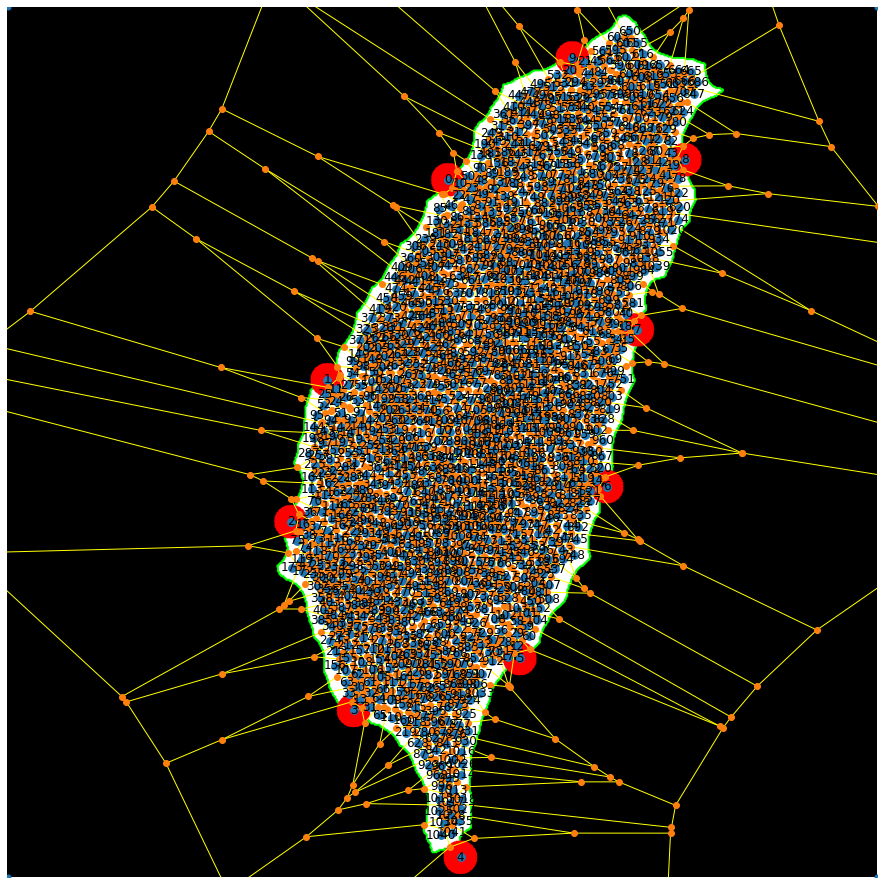

Color proportional to cell index


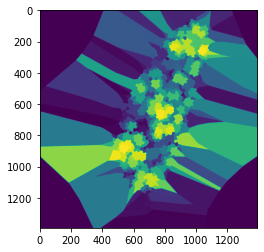

Same as last image but with the mask applied


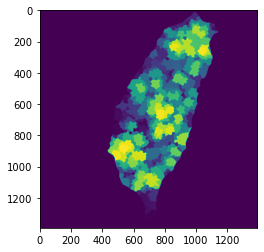

Shape mask


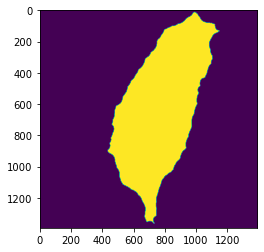

River Elevations


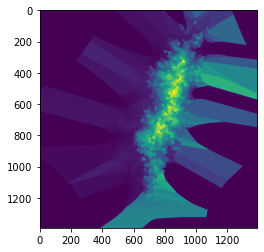

In [16]:
imgvoronoi = np.zeros(imgray.shape,dtype=np.uint16)                # zeroes in the shape of the input image
imgRiverHeights = np.zeros(imgray.shape,dtype=np.uint16)
from scipy.spatial import Voronoi, voronoi_plot_2d
points=[G.nodes[x]['pos'] for x in nodes]
points.append((0,0))                                               # adds points of the 4 corners of the image
points.append((0,img2.shape[1]))
points.append((img2.shape[0],0))
points.append((img2.shape[0],img2.shape[1]))

vor = Voronoi(points,qhull_options="Qbb Qc Qz Qx")                 # qhull options for the qhull library

pos=nx.get_node_attributes(G,'pos')                                # gets the 'pos' attributes of all nodes
#labels = list(map(lambda x: G.nodes[x]['priority'],nodes))
labels = list(map(lambda x: x,nodes))                              # I think these two lines make a dictionary
labels = dict(zip(nodes,labels))                                   # that associates each node with a label
#nx.draw_networkx_labels(G,pos)
'''
fig=voronoi_plot_2d(vor,line_colors='red')
fig.set_size_inches(16, 16, forward=True)
fig.set_dpi(80)
plt.imshow(img2,aspect='auto')
fig.set_tight_layour(True)
'''
ret, thresh = cv.threshold(imgray, 127, 1, 0)
mask = np.array(thresh, dtype=np.uint16)
mask*=(256*256-1)
voroniCount=1
for n in nodes:
    ridx=vor.point_region[n]  # index of the region the node is in
    if ridx==-1:              # if ridx is -1, then the node is not there, so skip this
        continue
    r = vor.regions[ridx]     # gets the indicies of the points forming the shape around the node
    debp = [vor.vertices[x].astype(int) for x in r if x!=-1] # creates a list of the node's vertices as integers
    debp = np.array( [ [ x[0],x[1] ] for x in debp] )   # recreates the list in a shape that cv can understand
    cv.fillPoly(imgvoronoi,[debp],np.int16(ridx+1).item()) # fills the voronoi polygon with the region index?
    cv.fillPoly(imgRiverHeights,[debp],np.int16(G.nodes[n]['elevation']).item())
    voroniCount+=1

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
ax.imshow(img2)
ylim=ax.get_ylim();
xlim=ax.get_xlim();
nx.draw(G,pos,node_size=60,labels=labels,ax=ax)
voronoi_plot_2d(vor, point_size=10, ax=ax,line_colors=['yellow']) # draws the voronoi cells?
ax.set_ylim(ylim);
ax.set_xlim(xlim);
kernel = cv.getStructuringElement(cv.MORPH_RECT,(2,2))#I have no idea what this is, and it isn't used anywhere else
plt.show()
print("Color proportional to cell index")
plt.imshow(imgvoronoi)
imgvoronoi = cv.bitwise_and(imgvoronoi,mask)

plt.show()
print("Same as last image but with the mask applied")
plt.imshow(imgvoronoi)

plt.show()
print("Shape mask")
plt.imshow(mask)

plt.show()
print('River Elevations')
plt.imshow(imgRiverHeights)

### Breakdown of the image
# Giant red circles identify river mouths
# Blue dots identify river nodes
# Black arrows point upstream
# Black numbers identify the order of the nodes
# Green outline identifies the coast
# Yellow lines outline the voronoi cells around each river node
# Yellow dots identify the vertices of the voronoi cells



In [17]:
np.unique(imgvoronoi)

array([   0,    2,    3, ..., 1173, 1174, 1175], dtype=uint16)

In [18]:
print([G.nodes[i]['elevation'] for i in G.nodes])
print([G.nodes[i]['priority']  for i in G.nodes])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2.13640408644653, 1.7639474633421512, 1.000438714746125, 3.4829039998268776, 23.51372105299479, 0.0, 1.9112257080491153, 1.2127536212675145, 0.0, 1.9225784832740742, 31.54578603301446, 1.3536165440235608, 5.6220358174016365, 2.6525923034073706, 5.077006202547679, 3.9110318511657067, 4.417112752423172, 2.944419767574346, 1.000438714746125, 1.000438714746125, 4.539310658167869, 4.344745917871779, 6.770899303659465, 5.3094634281665005, 0.0, 0.0, 2.3020363411914206, 4.460458447321057, 2.1244748356290373, 31.219479079917715, 31.18737554107486, 4.28327802826326, 2.6954086325319455, 4.274303242574586, 9.240521364932102, 28.082418561103133, 6.522017406524858, 5.984833227991147, 4.463732340223235, 4.022791379334373, 4.030531426925297, 8.602164371102495, 7.8552179468650865, 7.884712774517096, 3.3747486671180096, 4.971948414771272, 59.7308503038415, 58.000289358361705, 1.2298396547565542, 1.3243351065212208, 1.095454010398866, 5.59496930317985, 5.495657403455949, 4.

### voronoiimg has the watersheds where pixels of value  centernodeidx + 1 are pixels that belong to watershed of node centernodeidx, since there is only one s for each node ( that is the incoming edge from the parent ), we can calculate the watershed areas and store them into each node

In [19]:
# calculate watershed areas
for node in nodes:
    pos = G.nodes[node]['pos']
    pixelVal = imgvoronoi[int(pos[1])][int(pos[0])]
    area = np.count_nonzero(imgvoronoi==pixelVal)
    G.nodes[node]['localwatershedarea']=area

    

In [20]:
# calculate the total area of the watershed behind the node
# also calculate the flow through the node
for node in nx.dfs_postorder_nodes(G):  # search nodes in a depth-first post-ordering manner
    localWatershed = G.nodes[node]['localwatershedarea']
    Watershed =localWatershed+ sum([G.nodes[src]['inheritedwatershed'] for src in G.successors(node)])
    G.nodes[node]['inheritedwatershed']=Watershed                         # calculate total watershed area
    G.nodes[node]['flow'] =0.42*G.nodes[node]['inheritedwatershed']**0.69 # calculate river flow


In [21]:
#### Voronoi vertex v1,v2 accesses pixelvalue of img at [v2,v1]
# calcualte Zs of Qs, for each q its the max of the input nodes that has q in its region, plus a random margin

### Explainer
# The Qs are the vertices of the voronoi cells
# I think that "Zs of Qs" refers to the altitudes of those vertices

# Parallel arrays are bad practice. This must be reformed
qz={} # elevation 
qd={} # distance between q and the node
ql={} # location (x,y) of each point
for n in nodes:                    # loop through all nodes (obviously)
    r=vor.point_region[n]
    if r==-1:
        continue
    for vertex in vor.regions[r]:  # loop through all the vertices of the voronoi cell around the node
        #print(n,r,vertex,vor.vertices[vertex])
        if  not(0<= int(vor.vertices[vertex][0]) < (imgray.shape[0] - 5) and 0<= int(vor.vertices[vertex][1]) < (imgray.shape[1] - 1)) :
            #print(f'x: {vor.vertices[vertex][0]} y: {vor.vertices[vertex][1]}')
            continue ## ignore vertices outside of the image
        #print(vertex)
        if vertex not in qz: # ignore vertices that have already been processed
            qz[vertex]=0
            #print(vertex)
            #print(f'x: {vor.vertices[vertex][0]} y: {vor.vertices[vertex][1]}')
            slope = terrainSlope[int(vor.vertices[vertex][0]), int(vor.vertices[vertex][1])] / 255
                         # I'm pretty sure that 'norm' just means 'distance', in this case
                                                    # position of the vertex relative to the node
                                    # coordinates of the vertex # coordinates of the node
            qd[vertex] = np.linalg.norm( vor.vertices[vertex] - G.nodes[n]['pos'])
        qz[vertex ]= max(qz[vertex],G.nodes[n]['elevation']) # (generally) sets the elevation to the node's elevation

        # creates a list of coordinates for the vertices in the region
        # is this used _anywhere_ else?
        qs = [vor.vertices[x].astype(int) for x in vor.regions[n] if x!=-1]
        
        # This is used in the terrain slope function
        ql[vertex] = vor.vertices[vertex]
    

In [22]:
# All this does is increase the altitude of
# those voronoi vertices by a random amount
for q in qz:
    slope = terrainSlope[int(ql[q][0]), int(ql[q][1])] / 255
    #qz[q]*=slope
    #pass
    qz[q]+= (random.uniform(0,5) *qd[q]) * slope # TODO terrain slope map
    #qz[q]+=5

In [23]:
#qvals = [imgray[int(vertex[1]),int(vertex[0])] for vertex in vor.vertices if  0<=  vertex[0] < imgray.shape[0] and 0<=  vertex[1] < imgray.shape[1]]

In [24]:
def classify(Node):
    # Based on river slope and distance from Gamma
    # TODO: A real classification
    es = G.out_edges(Node)
    es = list(es)
    for e in es:
        grade=(G.nodes[e[1]]['elevation']-G.nodes[e[0]]['elevation'])/edgeLength
        if grade > 0.1:
            G.nodes[e[1]]['rosgen']='A+'
        elif grade >0.04:
            G.nodes[e[1]]['rosgen']='A'
        elif grade > 0.02:
            G.nodes[e[1]]['rosgen']=['G','D','B'][random.randint(0,2)];
        elif grade > 0.005:
            G.nodes[e[1]]['rosgen']=['C','D','E','F'][random.randint(0,3)];
        else :
            G.nodes[e[1]]['rosgen']='DA'
            
from itertools import islice

def window(seq, n=2): ##Borrowed as is
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
def clean_asin(sinAngle): ## Borrowed but modified
    return math.asin(min(1,max(sinAngle,-1)))

In [25]:
for n in nodes:
    classify(n)

In [26]:
# Remebmer: incoming edges are downstream; outgoing edges are upstream
#Create confluences, to do that, sort the outgoing edges(these are the inlets to the node) by the angle they form with the node
import math
for n in nodes:
    es = G.out_edges(n)
    ie = G.in_edges(n)
    
    # There ought to be a single incoming (downstream) edge unless it is a mouth.
    # Otherwise, there ought to be one, and no more
    if len(list(ie))==0:
        continue
    assert( (len(list(ie))==1 ))
    
    ie = list(ie)[0]
    vRef = np.subtract(G.nodes[ie[1]]['pos'],G.nodes[ie[0]]['pos'])
    vRef = vRef / np.linalg.norm(vRef)
    
    # sorts the outgoing (upstream) edges by the angle they form with the node
    es = list(es);
    es.sort(key = lambda r : clean_asin((np.cross(np.subtract(G.nodes[r[1]]['pos'],G.nodes[r[0]]['pos'])/np.linalg.norm(np.subtract(G.nodes[r[1]]['pos'],G.nodes[r[0]]['pos'])),vRef))),reverse = True)
    # es now contains edges sorted by the angle they form with the source vector
    wes = window(es)
    #print(es)
    #for upstream in wes:
        # create junctions
    #    print(upstream[0],upstream[1])
    
    # I didn't bother to make sense of this, but I guess this is where confluences are created
    ks=[]
    for e in wes:
        angle = random.uniform(0,10)
        if G.nodes[e[0][1]]['priority']!=G.nodes[e[1][1]]['priority']:
            angle+=80
        ks+=[angle]
    
    lastconfluence=None
    if len(ks)==0:
        # connect the only upstream node to the outlet
        None
    else:
        # create confluence between memebers of ks, then connect last confluence to outlet
        None

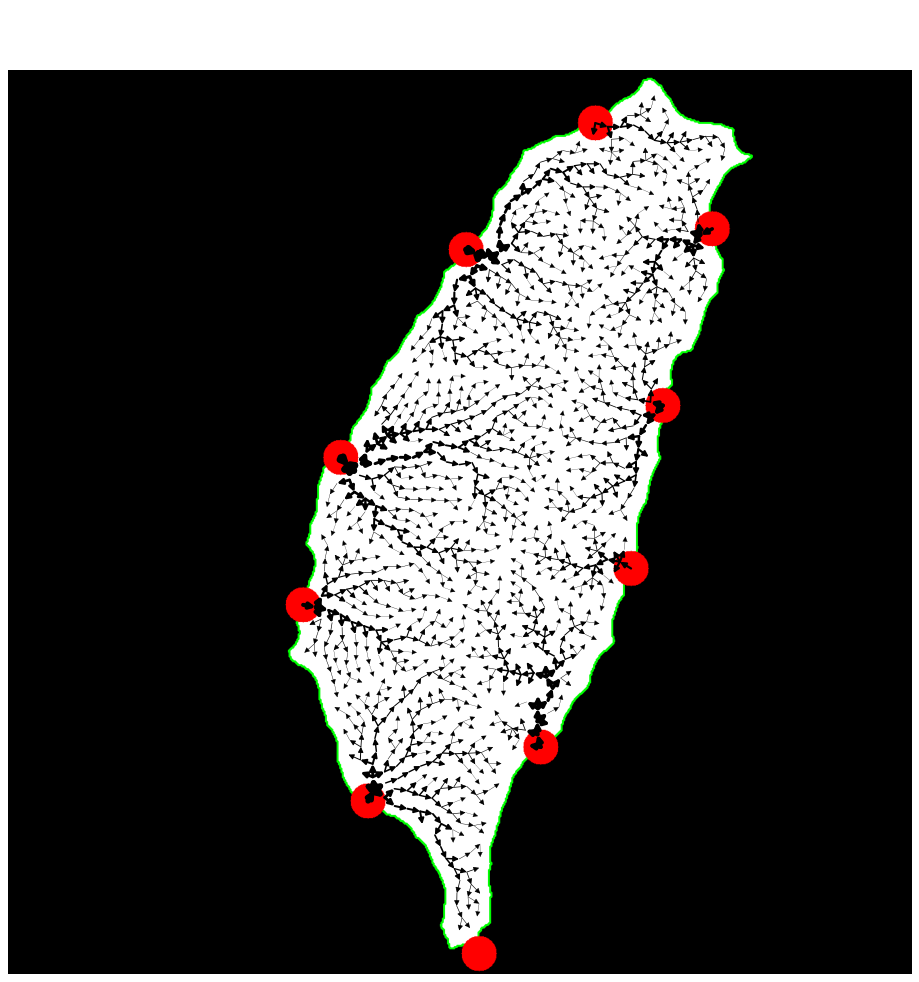

In [27]:
# This is a node graph, like the voronoi graph earlier. But the arrows are weighted by flow

plt.figure(num=None, figsize=(16, 16), dpi=80)
pos=nx.get_node_attributes(G,'pos')
plt.imshow(img2)
#labels = list(map(lambda x: G.nodes[x]['priority'],nodes))
labels = list(map(lambda x: x,nodes)) # I'm not sure why labels is redefined here
labels = dict(zip(nodes,labels))
#nx.draw_networkx_labels(G,pos)
normalizer =max([G.nodes[u]['flow'] for u in nodes]) 
weights = [6*G.nodes[u]['flow']/normalizer for u,v in G.edges]

#nx.draw(G,pos,node_size=10,labels=labels,width=weights)
nx.draw(G,pos,node_size=0,width=weights)


In [28]:
# Draw a map of rivers

In [29]:
# This is the least intuitive way to calculate Euclidean distance, but I respect it
def distance(a,b):
   return np.linalg.norm( np.subtract(a , b))


In [30]:
# This just gets the highest elevation in the entire map

maxNodeElevation = max([G.nodes[n]['elevation'] for n in nodes])
print(f'Highest Node: {maxNodeElevation}')
maxqElevation = max(qz.values())
print(f'Highest Ridge Elevation: {maxqElevation}')
maxZ = max([maxNodeElevation,maxqElevation])


Highest Node: 222.9524783975024
Highest Ridge Elevation: 268.8850154596898


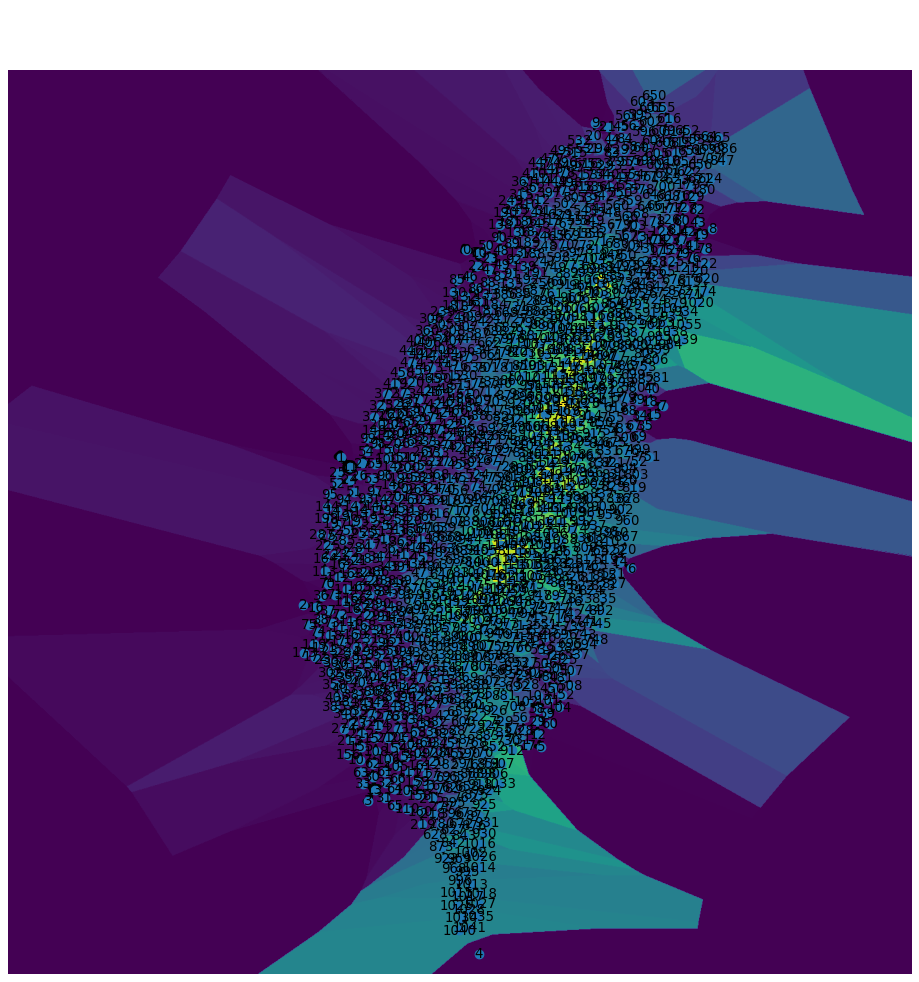

In [31]:
# Same thing, but over imgvoronoi instead of the map

plt.figure(num=None, figsize=(16, 16), dpi=80)
pos=nx.get_node_attributes(G,'pos') # I don't know why this is redefined here in exactly the same way as before
plt.imshow(imgRiverHeights)
labels = list(map(lambda x: x,nodes))
labels = dict(zip(nodes,labels))
normalizer =max([G.nodes[u]['flow'] for u in nodes]) 
weights = [6*G.nodes[u]['flow']/normalizer for u,v in G.edges]

nx.draw(G,pos,node_size=60,labels=labels,width=weights)

In [32]:
#Borrowed, heavily modified
from poisson import PoissonGenerator

disk = False                # this parameter defines if we look for Poisson-like distribution on a disk/sphere (center at 0, radius 1) or in a square/box (0-1 on x and y)
repeatPattern = True        # this parameter defines if we look for "repeating" pattern so if we should maximize distances also with pattern repetitions
num_points = 50              # number of points we are looking for
num_iterations = 4          # number of iterations in which we take average minimum squared distances between points and try to maximize them
first_point_zero = disk     # should be first point zero (useful if we already have such sample) or random
iterations_per_point = 128  # iterations per point trying to look for a new point with larger distance
sorting_buckets = 0         # if this option is > 0, then sequence will be optimized for tiled cache locality in n x n tiles (x followed by y)
num_dim = 2                 # 1, 2, 3 dimensional version
num_rotations = 1           # number of rotations of pattern to check against

allteepoints = []         # Tee is a terrain primitive
taos_for_regions = {}     # I have no idea what this is, and I don't think it's used anywhere
poisson_generator = PoissonGenerator( repeatPattern, first_point_zero)
points = poisson_generator.find_point_set(num_points, num_iterations, iterations_per_point, num_rotations)
for n in nodes:
    r = vor.regions[vor.point_region[n]]
    ridge_positions = { x:(vor.vertices[x].astype(int)[0],vor.vertices[x].astype(int)[1]) for x in r if x!=-1 }
    reg = list(ridge_positions.values()) # converts ridge_positions from a dictionary to a list of tuples (coordinates)
    rreg = [[x[0],x[1]] for x in reg]    # converts reg from a list of tuples to a 2-D array
    rreg= np.array(rreg)                 # converts again, using numpy
    idxes = np.where(imgvoronoi==vor.point_region[n]+1) # coordinates of all pixels in the voronoi region
    xllim = min(x for x in idxes[0]) # these lines get the bounding box of the voronoi region
    xulim = max(x for x in idxes[0])
    yllim = min(x for x in idxes[1])
    yulim = max(x for x in idxes[1])
    
    # I don't know why he creates another bounding box with opencv
    b= np.array([[xllim,yllim],[xllim,yulim],[xulim,yllim],[xulim,yulim]])
    b=cv.minAreaRect(b)
    pts = cv.boxPoints(b)
    xllim = int(min(x[0] for x in pts))
    xulim = int(max(x[0] for x in pts))
    yllim = int(min(x[1] for x in pts))
    yulim = int(max(x[1] for x in pts))
    
    # I think this applies a mask to the poisson points, and adds those points as Tees for the cell
    points_projected = [ [int(p[0]*(yulim-yllim)+yllim),int(p[1]*(xulim-xllim)+xllim)] for p in points ]
    points_filtered = [ (p[0],p[1]) for p in points_projected if imgvoronoi[p[1]][p[0]]==vor.point_region[n]+1 ]
    allteepoints+=points_filtered
    
    # I'm not sure what this does
    taos_for_regions[vor.point_region[n]]=points_filtered
    
    clear_output(wait=True)
    print(n," out of ",len(nodes))  # use display(f) if you encounter performance issues

1169  out of  1170


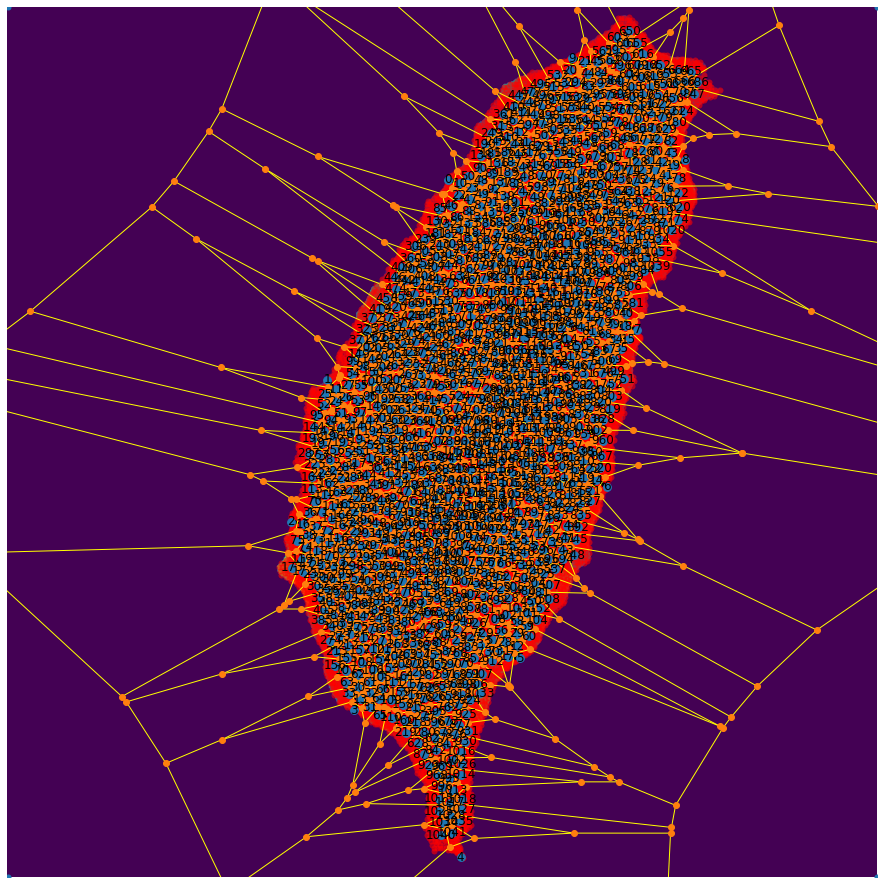

In [33]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(111)
ax.imshow(imgvoronoi)
ax.scatter(*zip(*allteepoints), color='r', alpha=0.6, lw=0)

ylim=ax.get_ylim();
xlim=ax.get_xlim();
nx.draw(G,pos,node_size=60,labels=labels,ax=ax)
voronoi_plot_2d(vor, point_size=10, ax=ax,line_colors=['yellow'])

ax.set_ylim(ylim);
ax.set_xlim(xlim);
plt.show()


In [34]:
def projection(p,u,v):
    n = np.subtract(u,v)
    nnorm = np.linalg.norm(n, 2)
    n = n/nnorm
    ret = np.dot(np.subtract(p,v), n)
    proj = ret/nnorm
    if proj >1 :
        proj=1
    if proj <0 :
        proj =0
    return proj*n

In [35]:
import shapely.geometry as geom
import numpy as np
from shapely.geometry import asLineString

point = geom.Point(0.8, 10.5)

# Note that "line.distance(point)" would be identical

# This is a dictionary of nodes. I think it stores
# the path to the seeeee for each node
rivers = {}

for n in mouthnodes:
    # remember that out_edges gets upstream nodes
    leaves = [s for s in nx.descendants(G,n) if len(G.out_edges(s))==0]
    for leaf in leaves: # essentially, this loops through all the highest nodes of a particular mouth
        path = nx.shortest_path(G,n,leaf) # path to the leaf (there's only one, so it's the shortest)

        x = np.array([G.nodes[p]['pos'][0] for p in path])
        y = np.array([G.nodes[p]['pos'][1] for p in path])
        z = np.array([G.nodes[p]['elevation'] for p in path])
        
        # it seems to me that, if the path is short, this block
        # adjusts the positions of the first three nodes
        if len(x)<4:
            x1 = (x[0]+x[1])/2
            x2 = (x[0]+x1)/2
            y1 = (y[0]+y[1])/2
            y2 = (y[0]+y1)/2
            z1 = (z[0]+z[1])/2
            z2 = (z[0]+z1)/2
            tmp = x[1:]
            x = [x[0],x2,x1]+list(tmp)
            x = np.array(x)
            tmp=y[1:]
            y = [y[0],y2,y1]+list(tmp)
            y = np.array(y)
            tmp=z[1:]
            z = [z[0],z2,z1]+list(tmp)
            z = np.array(z)
        
        # I think that this is where the river paths are smoothed
        tck, u = interpolate.splprep([x, y,z], s=0)
        unew = np.arange(0, 1.01, 0.05)
        out = interpolate.splev(unew, tck)
        
        lstr=[] # lstr is apparently "line string"
        dbg=[] # I think this is to verify that altitude increases continually
        for i in range(len(out[0])): # loops through each coordinate created in interpolation
            lstr.append((out[0][i],out[1][i],int(out[2][i])))
            dbg.append(int(out[2][i]))
        line = asLineString(lstr)
        
        for p in path: # for each node in the path to this particular leaf
            # I'm pretty sure this loop ensures that
            # the path to the sea is up to date
            if p in rivers:
                rivers[p].append(line)
            else:
                rivers[p]=[line]

In [36]:
print(dbg)

[0, -2, -1, 3, 10, 17, 24, 28, 29, 28, 28, 29, 30, 31, 31, 31, 31, 31, 31, 31, 31]


In [37]:
# TODO:Calculate Zees for Cees of Tees ( Elevations of center points of terrain primitives)

czs = {}
for t in allteepoints:
    ridx = imgvoronoi[t[1]][t[0]] - 1
    
    # find distance to closest sgment, and elevation at that point
    closestRdist = None
    ridgeElevation = None
    for r in range(len(vor.regions[ridx])):
        if vor.regions[ridx][r-1] not in qz or vor.regions[ridx][r] not in qz:
            continue
        p1 = vor.vertices[vor.regions[ridx][r-1]]
        p2 = vor.vertices[vor.regions[ridx][r]]
        dist, isToEndpoint = point_segment_distance_is_endpoint(
            t[0],t[1],
            p1[0],p1[1],
            p2[0],p2[1]
        )
        if closestRdist is not None and dist > closestRdist:
            continue
        if isToEndpoint:
            if distance(p1,t) < distance(p2,t):
                closestRdist = distance(p1,t)
                ridgeElevation = qz[vor.regions[ridx][r-1]]
            else:
                closestRdist = distance(p2,t)
                ridgeElevation = qz[vor.regions[ridx][r]]
        else:
            closestRdist = dist
            p1elevation = qz[vor.regions[ridx][r-1]]
            p2elevation = qz[vor.regions[ridx][r]]
            ridgeElevation = \
                p1elevation + \
                (math.sqrt(distance(p1,t)**2 - dist**2) / distance(p1,p2)) * \
                (p2elevation - p1elevation)
    
    # see if the seeeeee is closer
    dist_gamma = cv.pointPolygonTest(contour,(t[1],t[0]),True)
    if (dist_gamma < closestRdist):
        closestRdist = dist_gamma
        ridgeElevation = 0
    
    point = geom.Point(t[0],t[1])
    nodeOfregion = list(vor.point_region).index(ridx)
    projected = None
    distancefromN = None
    if nodeOfregion in rivers:
        local_rivers = rivers[nodeOfregion] # tries to get a line to the seeeee
        # index of the point on the interpolated river line that is closest to the Tee point
        rividx = [point.distance(x) for x in local_rivers].index(min([point.distance(x) for x in local_rivers]))
        # gets the point along the river that is the distance along the river to the point nearest to the Tee
        projected = local_rivers[rividx].interpolate(local_rivers[rividx].project(point))
        distancefromN = point.distance(local_rivers[rividx]) # distance to that point
    else: # handle cases of stub rivers
        projected = geom.Point(G.nodes[ridx]['pos'][0],G.nodes[ridx]['pos'][1],G.nodes[ridx]['elevation'])
        distancefromN = point.distance(projected)
    
    if distancefromN==0 and closestRdist==0:
        distancefromN=1
    
    lerpedelevation = projected.z*(closestRdist/(closestRdist+distancefromN))+ridgeElevation*(distancefromN/(closestRdist+distancefromN))
    
    czs[t] = lerpedelevation

##############################
#    
#    i = t[1] # y
#    j = t[0] # x
#
#    ridx = imgvoronoi[i][j]-1 # the region id that the point is in
#    r = vor.regions[ridx]     # the vertices of the voronoi cells
#    ridge_positions = { x:(vor.vertices[x].astype(int)[0],vor.vertices[x].astype(int)[1]) for x in r if x!=-1 and 0<=  vor.vertices[x].astype(int)[0] < imgray.shape[0] and 0<=  vor.vertices[x].astype(int)[1] < imgray.shape[1]}
#    #ridge_positions = np.array([[x[0],x[1]] for x in verts_in_r if 0<=  x[0] < imgray.shape[0] and 0<=  x[1] < imgray.shape[1]]) 
#    ridge_elevations = { x:qz[x] for x in r if x  in qz }
#    r_refined = list(ridge_positions.keys())
#    
#    #find closest ridge point
#    closestR =r_refined[[distance((j,i),ridge_positions[x]) for x in r_refined].index(min([distance((j,i),ridge_positions[x]) for x in r_refined]))]
#    elevationAtClosestR = ridge_elevations[closestR]
#    dist_gamma =cv.pointPolygonTest(contour,(i,j),True) # distance to Gamma (the coast? or the river?)
#    distanceFromR = distance((j,i),ridge_positions[closestR]) # distance to closest ridge point
#    
#    if(dist_gamma<distanceFromR): # if the coast is closer than the closest ridge, then...
#        distanceFromR = dist_gamma
#        elevationAtClosestR= 0 #10 # I guess this is the elevation at the coast
#    #point.distance(rivers[n])
#    point = geom.Point(j,i) # creates an instance of the Geometry package point class
#    nodeOfregion = list(vor.point_region).index(ridx)
#    
#    projected = None # this ought to be the location of the river node (should use rdix)
#    distancefromN = None # this ought to be the distance to that node
#    if nodeOfregion in rivers:
#        local_rivers = rivers[nodeOfregion] # tries to get a line to the seeeee
#        #print(local_rivers)
#        # index of the point on the interpolated river line that is closest to the Tee point
#        rividx = [point.distance(x) for x in local_rivers].index(min([point.distance(x) for x in local_rivers]))
#        # gets the point along the river that is the distance along the river to the point nearest to the Tee
#        projected = local_rivers[rividx].interpolate(local_rivers[rividx].project(point))
#        distancefromN = point.distance(local_rivers[rividx]) # distance to that point
#    else:
#        projected = geom.Point(G.nodes[ridx]['pos'][0],G.nodes[ridx]['pos'][1],G.nodes[ridx]['elevation'])
#        distancefromN = point.distance(projected)
#    
#    if distancefromN==0 and distanceFromR==0:
#        distancefromN=1
#    # f2ik I think this is an interpolated elevation?
#    lerpedelevation = projected.z*(distanceFromR/(distanceFromR+distancefromN))+elevationAtClosestR*(distancefromN/(distanceFromR+distancefromN))
#    fixed = lerpedelevation
#    #clear_output(wait=True)
#    #print(len(czs)," out of ",len(allteepoints))  # use display(f) if you encounter performance issues
#
#    # find edges of node to which j,i are closest
#    #es = list(G.out_edges(n))+list(G.in_edges(n))
#    #closestEdge = [point_segment_distance_tuple((j,i),G.nodes[e[0]]['pos'], G.nodes[e[1]]['pos']) for e in es].index(min([point_segment_distance_tuple(j,i),G.nodes[e[0]]['pos'], G.nodes[e[1]]['pos']) for e in es]))
#    czs[t]=fixed
#
# Add ridges as terrain primitives
#for q in ql:
#    #print(f'x:{ql[q][0]} y:{ql[q][1]}')
#    t = (int(ql[q][0]),int(ql[q][1]))
#    allteepoints.append(t)
#    czs[t] = qz[q]

czsall = [czs[t] for t in allteepoints]
allpoints_list = [[x[0],x[1]] for x in allteepoints]
allpoints_nd = np.array(allteepoints)
apkd = cKDTree(allpoints_nd)

discard = imgray.copy()
radius = 0
while np.where(discard==255)[0].shape[0] >0:
    radius+=1;
    for tao in allteepoints:
        cv.circle(discard,tao, radius, (0,0,0),-1)



In [38]:
def TerrainFunction(prePoint):
    point = [int(prePoint[0] * (imgray.shape[0] / outputResolution)),int(prePoint[1] * (imgray.shape[0] / outputResolution))]
    
    if imgray[point[1]][point[0]]==0:
        return 0

    # Gets and computes influence and elevation values for nearby terrain primitives
    ts = apkd.query_ball_point(point,radius * (imgray.shape[0] / outputResolution)) # Gets all terrain primitives within a radius of the point
    if len(ts) < 1: # if there just aren't any T points around, just put it in the ocean
        return 0
    wts = [w(distance(point,allteepoints[t])) for t in ts] # "influence field" radii of those primitives
    # TODO: I think this end up getting different heights for
    hts = [ht(point,allteepoints[t]) for t in ts]          # elevations of those primitives

    # Blends the terrain primitives
    ht_ = height_b(hts,wts) # Blends those terrain primitives
    wt_ = wts[0]            # I guess this is supposed to be the influence radius of the closest primitive?
    
    wi=wt_ # IDK why he converts these here
    hi=ht_
    
    # Prepares to carve the terrain with the river
    ridx = imgvoronoi[point[1]][point[0]]-1 # Region id of voronoi cell
    if ridx==-1:
        return hi
    node = list(vor.point_region).index(ridx) # This just gets the number of the node
    geomp = geom.Point(point[0],point[1])     # Creates a Shapely point out of the input point
    rs = [ ]
    hrs = [ ]
    wrs = [ ]
    if node in rivers: # Sometimes there isn't a river, just a drainage point along the seeeee
        rs  = [e for e in rivers[node] if geomp.distance(e) < radius * (imgray.shape[0] / outputResolution) ]
        hrs = [hr(geomp,e) for e in rs]
        wrs = [w(geomp.distance(e)) for e in rs]
    else:
        riverPoint = geom.Point(G.nodes[ridx]['pos'][0],G.nodes[ridx]['pos'][1],G.nodes[ridx]['elevation'])
        if geomp.distance(riverPoint) < radius * (imgray.shape[0] / outputResolution):
            rs = [ geomp.distance(riverPoint) ]
            hrs = [ river.z ]
            wrs = [ w(geomp.distance(riverPoint)) ]

    # Height and "influence field" calculation per the last equation in Section 7
    # This is the so-called "replacement operator"
    for i in range(len(rs)): 
        hi=(1-wrs[i])*hi+wrs[i]*hrs[i] 
        wi = (1-wrs[i])*wi+wrs[i]**2

    if hi<0:
        #print(hrs,wrs)
        pass
    
    return hi

def height_b(h,w): # height function of a blend node (section 7)
    try:
        ret = np.sum(np.multiply(h,w))/(np.sum(w))
        assert(ret>=0)
        assert(not np.isnan(ret)) # make sure ret is a number
        return ret
    except:
        return 0

scale = 100.0 # I think adjusting these values could be useful
octaves = 6
persistence = 0.5
lacunarity = 2.0
def ht(p,t): # Height of a terrain primitive
    return czs[t] +pnoise2(p[0]/scale,p[1]/scale,octaves=octaves,persistence=persistence,lacunarity=lacunarity,repeatx=imgray.shape[0],repeaty=imgray.shape[1],base=0)*10


def hr(p,r): # Height of a river primitive?
    d=p.distance(r)
    # TODO profile based on Rosgen classification
    segma = 0.1 * min(rwidth**2,d**2) # I think this is the river profile (evidently the author can't read Greek)
    projected = r.interpolate(r.project(p))
    #if projected.z<0:
    #    print("0")
    return projected.z+segma


def w(d): # This returns the "influence field" (section 7)
    if d <1:
        return 1;
    return (max(0,((radius*(imgray.shape[0]/outputResolution))+1)-d)/(((radius*(imgray.shape[0]/outputResolution))+1)*d))**2

100%|██████████| 500/500 [05:04<00:00,  1.64it/s]


End: 2021-01-15 16:17:16.214060
render time:  0:05:04.555672


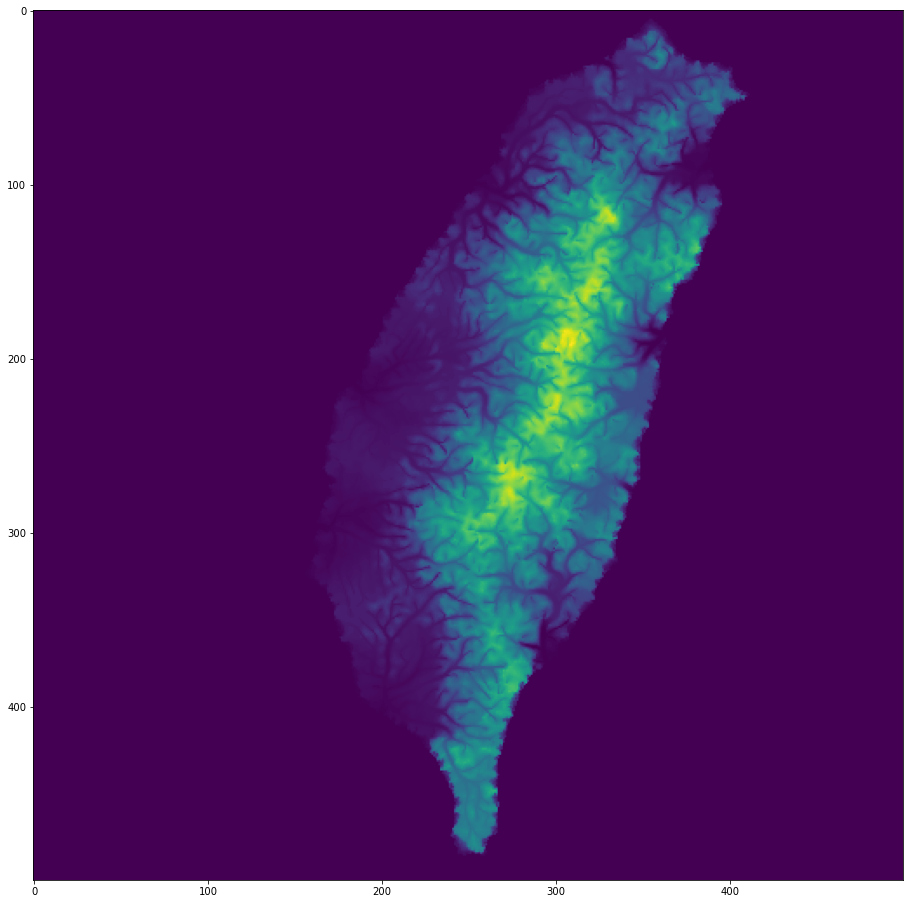

In [39]:
from tqdm import trange
s= datetime.datetime.now()
imgTest = np.zeros((outputResolution,outputResolution),dtype='double')
maxT=s-s;
ijAtMaxT=None
for i in trange(outputResolution): #, desc='1st loop'):
    for j in range(outputResolution): #trange(imgray.shape[1], desc='2nd loop',leave=False):
        ts =  datetime.datetime.now()
        imgTest[i][j] = max(0,TerrainFunction((j,i)))
        te =  datetime.datetime.now()
        if (te-ts) > maxT:
            maxT= te-ts
            ijAtMaxT = (i,j)
fig = plt.figure(figsize=(16,16))
plt.imshow(imgTest)
e=datetime.datetime.now()
print("End:",e)
print("render time: ", e -s )


In [40]:
# this doesn't work because
immtt = np.array(imgTest)
normalizedImg = immtt.copy()
cv.normalize(immtt,  normalizedImg, 0, 255, cv.NORM_MINMAX)
normalizedImg = normalizedImg.astype('uint8')
cv.imwrite("taiwan-out.png",normalizedImg)

IndexError: index 800 is out of bounds for axis 0 with size 500

In [ ]:
endTime = datetime.datetime.now()
print("Total time: ", endTime -startTime )

In [ ]:
maxT.asdads

In [ ]:


s= datetime.datetime.now()
print("start:",s)
#imgTest = np.zeros(imgray.shape,dtype='uint8')
 
print(TerrainFunction((326, 196)))
print(TerrainFunction((196, 326)))

e=datetime.datetime.now()
print("End:",e)
print("render time: ", e -s )

In [ ]:
s= datetime.datetime.now()
print("start:",s)
#imgTest = np.zeros(imgray.shape,dtype='uint8')

imgTest = [[TerrainFunction((j,i)) for j in range(128,160)] for i in range(128,160)]

plt.imshow(imgTest)
e=datetime.datetime.now()
print("End:",e)
print("render time: ", e -s )

In [ ]:
print(point_segment_distance_is_endpoint(
    6,0,
    0,0,
    5,0
))